In [8]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [9]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [7]:
!ls /g/data/ua8/LE_models/20CRv3/mean_daily/prmsl

prmsl.1836.nc  prmsl.1872.nc  prmsl.1908.nc  prmsl.1944.nc  prmsl.1980.nc
prmsl.1837.nc  prmsl.1873.nc  prmsl.1909.nc  prmsl.1945.nc  prmsl.1981.nc
prmsl.1838.nc  prmsl.1874.nc  prmsl.1910.nc  prmsl.1946.nc  prmsl.1982.nc
prmsl.1839.nc  prmsl.1875.nc  prmsl.1911.nc  prmsl.1947.nc  prmsl.1983.nc
prmsl.1840.nc  prmsl.1876.nc  prmsl.1912.nc  prmsl.1948.nc  prmsl.1984.nc
prmsl.1841.nc  prmsl.1877.nc  prmsl.1913.nc  prmsl.1949.nc  prmsl.1985.nc
prmsl.1842.nc  prmsl.1878.nc  prmsl.1914.nc  prmsl.1950.nc  prmsl.1986.nc
prmsl.1843.nc  prmsl.1879.nc  prmsl.1915.nc  prmsl.1951.nc  prmsl.1987.nc
prmsl.1844.nc  prmsl.1880.nc  prmsl.1916.nc  prmsl.1952.nc  prmsl.1988.nc
prmsl.1845.nc  prmsl.1881.nc  prmsl.1917.nc  prmsl.1953.nc  prmsl.1989.nc
prmsl.1846.nc  prmsl.1882.nc  prmsl.1918.nc  prmsl.1954.nc  prmsl.1990.nc
prmsl.1847.nc  prmsl.1883.nc  prmsl.1919.nc  prmsl.1955.nc  prmsl.1991.nc
prmsl.1848.nc  prmsl.1884.nc  prmsl.1920.nc  prmsl.1956.nc  prmsl.1992.nc
prmsl.1849.nc  prmsl.1885.nc  prmsl.19

In [12]:
path_p = '/g/data/ua8/LE_models/20CRv3/mean_daily/prmsl/*.nc'

In [17]:
# read in daily mean sea level pressure (mean across all 20CR members)
P_ds = xr.open_mfdataset(path_p)
del P_ds['time_bnds']
P_ds

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 65744)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1836-01-01 1836-01-02 ... 2015-12-31
Data variables:
    prmsl    (time, lat, lon) float32 dask.array<chunksize=(366, 181, 360), meta=np.ndarray>
Attributes: (12/24)
    Conventions:               CF-1.2
    title:                     mean Daily NOAA/CIRES/DOE 20th Century Reanaly...
    comments:                  Data are from \nNOAA/CIRES/DOE 20th Century Re...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   These data are available free of charge under ...
    spatial_resolution:        1.0 degree
    ...                        ...
    citation1:                 Slivinski, L. C, G. P. Compo, J. S. Whitaker, ...
    References:                https://www.psl.noaa.gov/data/gridded/data.20t...
    creator_name:              NOAA/PSL
    institution:               NOAA Physical Sciences Laboratory & CU/CIRES \...
    contact:                   psl.data@noaa.gov
    citation:                  Compo,G.P. <https://www.psl.noaa.gov/people/gi...

In [33]:
# resample to monthly
P_mon = P_ds.resample(time='M').min(dim='time')
P_mon

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 2160)
Coordinates:
  * time     (time) datetime64[ns] 1836-01-31 1836-02-29 ... 2015-12-31
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    prmsl    (time, lat, lon) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>

In [46]:
with dask.diagnostics.ProgressBar():
    P_mon.to_netcdf('MSLP_mon.nc')

[########################################] | 100% Completed |  2min 19.2s


P*40�S and P*65�S are the normalized monthly zonal sea level pressure (SLP) at 40�S and 65�S
The 30-year period from 1971-2000 is used for the normalization period. Note that this period is arbitrary and a switch to a different period would change the exact SAM values but would be unlikely to significantly alter any trends.
(true zonal mean was simply the mean of the 144 points along the appropriate parallel)

# need to normalise P40 and should probs save PRMSL monthly as a netcdf and also maybe SAM

In [48]:
# read in netcdf of monthly pressure
P_mon_ds = xr.open_dataset('MSLP_mon.nc')

In [49]:
# calculate the zonal mean mslp at 40 and 65S (to be used in calculating SAM)
P40S = P_mon_ds.sel(lat=-40).mean(dim='lon')
P65S = P_mon_ds.sel(lat=-65).mean(dim='lon')
P65S

<xarray.Dataset>
Dimensions:  (time: 2160)
Coordinates:
  * time     (time) datetime64[ns] 1836-01-31 1836-02-29 ... 2015-12-31
    lat      float32 -65.0
Data variables:
    prmsl    (time) float32 9.88e+04 9.872e+04 9.846e+04 ... 9.592e+04 9.68e+04

In [50]:
# set the dates for the normalisation period
start_date = '1971'
end_date = '2000'

In [51]:
# normalise the pressure values by dividing by 30-year average
norm40 = P40S.sel(time=slice(start_date, end_date)).mean(dim='time')
P40S_n = P40S/norm40

norm65 = P65S.sel(time=slice(start_date, end_date)).mean(dim='time')
P65S_n = P65S/norm65

In [52]:
SAM = P40S_n - P65S_n
SAM

<xarray.Dataset>
Dimensions:  (time: 2160)
Coordinates:
  * time     (time) datetime64[ns] 1836-01-31 1836-02-29 ... 2015-12-31
Data variables:
    prmsl    (time) float32 -0.009726 -0.007651 ... 0.009288 -0.0006816

In [58]:
e_date = ['1883-08-27']

ConversionError: Failed to convert value(s) to axis units: '1883-08-27'

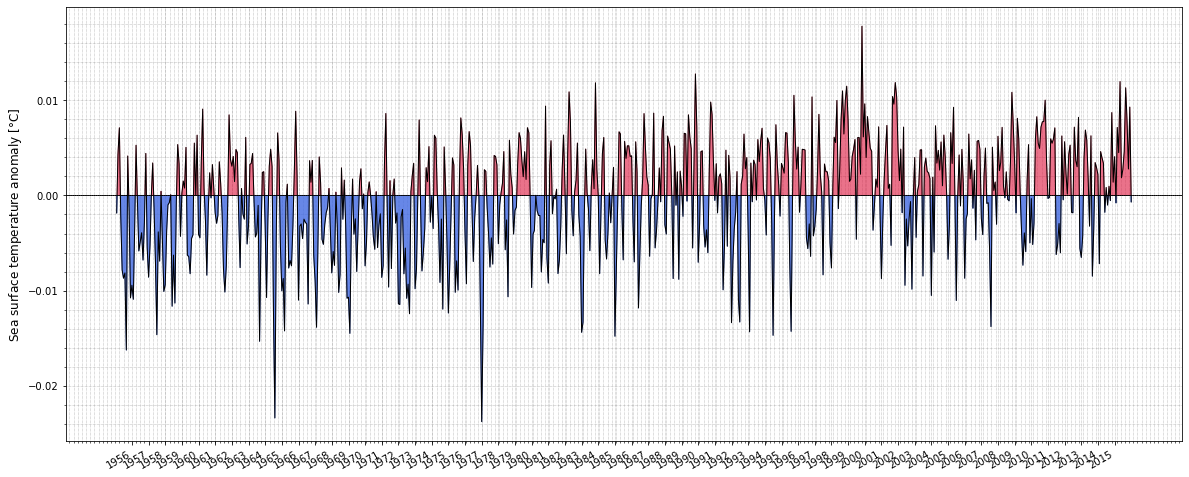

In [68]:
fig, axes = plt.subplots(1, 1, figsize=(20,8))
fplot.nino34_plot(SAM.prmsl.sel(time=slice('1955','2015')), e_date, 0, ax = axes)

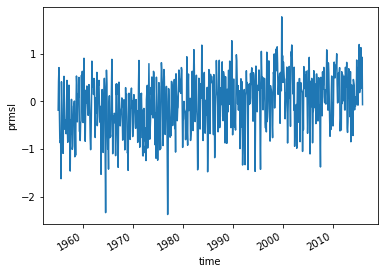

In [64]:
with dask.diagnostics.ProgressBar():
    (SAM*100).sel(time=slice('1955','2015')).prmsl.plot()